In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import max_error
import numpy as np

In [ ]:
data = pd.read_pickle(r"../data/B00020S.pkl")
data['Date'] = pd.to_datetime(data['Date'])

# TODO
 - **DONE** znaleźć prawidłowe offset_values — Max
 - **DONE** wykresy błędów — Adam
 - **DONE** nałożyć wartość bezwzględną na histogram błędu bezwzględnego — Adam
 - **DONE** upiększyć wykresy — Max
 - dodać do temp kolumnę z datami — Max
 - może jakiś opis matematyczny w markdownie tej regresji czy coś — Max albo Adam
 - **DONE** zautomatyzować dobór offset_values - Max

In [ ]:
# Słownik ze stacjami i odpowiadającymi im przesunięciom
stations_offset_values_dict = {
    'GŁOGÓW': 0,
    'ŚCINAWA': 1,
    'MALCZYCE': 1,
    'BRZEG DOLNY': 1,
    'OŁAWA': 2,
    'BRZEG': 2,
    'RACIBÓRZ-MIEDONIA': 3,
    'KRZYŻANOWICE': 3,
    'OLZA': 3,
    'CHAŁUPKI': 3
}

# Stacje
stations = ['GŁOGÓW', 'ŚCINAWA', 'MALCZYCE', 'BRZEG DOLNY', 'OŁAWA', 'BRZEG', 'RACIBÓRZ-MIEDONIA', 'KRZYŻANOWICE', 'OLZA', 'CHAŁUPKI']

# Lista różnic w dniach między Głogowem a kolejną stacją
offset_values = [stations_offset_values_dict[station] for station in stations]

# Rok, od którego chcemy trenować i testować model
start_year = 2019

# Grupowanie po dniach i stacjach
data_grouped = data.groupby(['Date', 'Station'])['B00020S'].mean().reset_index()

# Osobny dataframe dla każdej stacji i tylko rekordy od danego roku
station_datas = [data_grouped[(data_grouped['Station'] == station) & (data_grouped['Date'].dt.year >= start_year)].reset_index() for station in stations]

# Połączenie kolumn z poziomem wody z każdej stacji w jeden dataframe
temp = pd.concat([station_data['B00020S'] for station_data in station_datas], axis='columns').reset_index(drop=True)

# Zmiana nazw kolumn
temp.columns = stations

# Przesunięcie każdej kolumny o odpowiednią liczbę dni
for i, col in enumerate(temp.columns):
    temp[col] = temp[col].shift(periods=-offset_values[i])

# Usunięcie NA, możliwe, że później można to dopracować
temp = temp.dropna()

# Zmienne służące do podziału zbioru danych na zbiór treningowy i zbiór testujący
test_proportion = 0.2
train_proportion = 1 - test_proportion
split_point = int(len(temp) * train_proportion)

# Podział na zbiór treningowy i zbiór testowy
train_data, test_data = temp.iloc[:split_point], temp.iloc[split_point:]

# Zmienne niezależne
x = train_data.iloc[:, 1:]
x = sm.add_constant(x)

# Zmienna niezależna
y = train_data.iloc[:, 0]

# Dopasowanie modelu
model = sm.OLS(y, x).fit()

# Podsumowanie
print(model.summary())

## Resztki modelu

In [ ]:
# Dataframe z resztami modelu
residuals = pd.DataFrame(model.resid)

# Wykres reszt
fig, axes = plt.subplots(figsize=(36,32), ncols=1, nrows=2, gridspec_kw={'hspace': 0.3})
residuals.plot(ax = axes[0], linewidth=3)
axes[0].set_xlim(0, len(residuals))
axes[0].set_title('Reszty', fontsize=30)
axes[0].legend().set_visible(False)
axes[0].grid()

# Wykres gęstości jądra reszt / rozkład prawdopodobieństwa reszt
residuals.plot(kind='kde', ax=axes[1], linewidth=4)
axes[1].set_xlim(-100, 100)
axes[1].set_ylim(0, 0.03)
axes[1].set_title('Wykres gęstości jądra / rozkładu prawdopodobieństwa reszt', fontsize=30)
axes[1].set_ylabel('Gęstość', fontsize=20)
axes[1].legend().set_visible(False)
axes[1].grid()

plt.show()

# Statystyki opisowe reszt
print(residuals.describe())

## Predykcja modelu

In [ ]:
# Przewidywanie wartości na podstawie modelu
model_prediction = model.predict(x)

# To samo co wyżej, ale ręcznie
test_predict = model.params['const'] + sum(model.params[param] * test_data[param] for param in model.params.index[1:])

## Metryki błędu

In [ ]:
# Prawdziwe dane testowe
y_true = test_data.iloc[:, 0]

# Błąd średniokwadratowy
mse = mean_squared_error(y_true=y_true, y_pred=test_predict, squared=True)

# Pierwiastek z błędu kwadratowego
rmse = mean_squared_error(y_true=y_true, y_pred=test_predict, squared=False)

# Błąd procentowy średniokwadratowy
mape = mean_absolute_percentage_error(y_true=y_true, y_pred=test_predict)

# Maksymalny błąd bezwzględny
max_absolute_error = max_error(y_true=y_true, y_pred=test_predict)

# Maksymalny błąd względny
max_relative_error = max(abs((train_data['GŁOGÓW'] - test_predict) / test_data['GŁOGÓW']))

# Bezwzględny błąd treningowy
train_absolute_error = abs(train_data['GŁOGÓW'] - model_prediction)

# Względny błąd treningowy
train_relative_error = abs((train_data['GŁOGÓW'] - model_prediction) / train_data['GŁOGÓW'])

# Bezwzględny błąd testowy
test_absolute_error = abs(test_data['GŁOGÓW'] - test_predict)

# Względny błąd testowy
test_relative_error = abs((test_data['GŁOGÓW'] - test_predict) / test_data['GŁOGÓW'])

# Wyświetlenie niektórych powyższych metryk
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test max error: %.3f' % max_absolute_error)
print('Test max relative error: %.5f' % max_relative_error)

## Wykresy predykcji, błędu bezwzględnego i błędu względnego

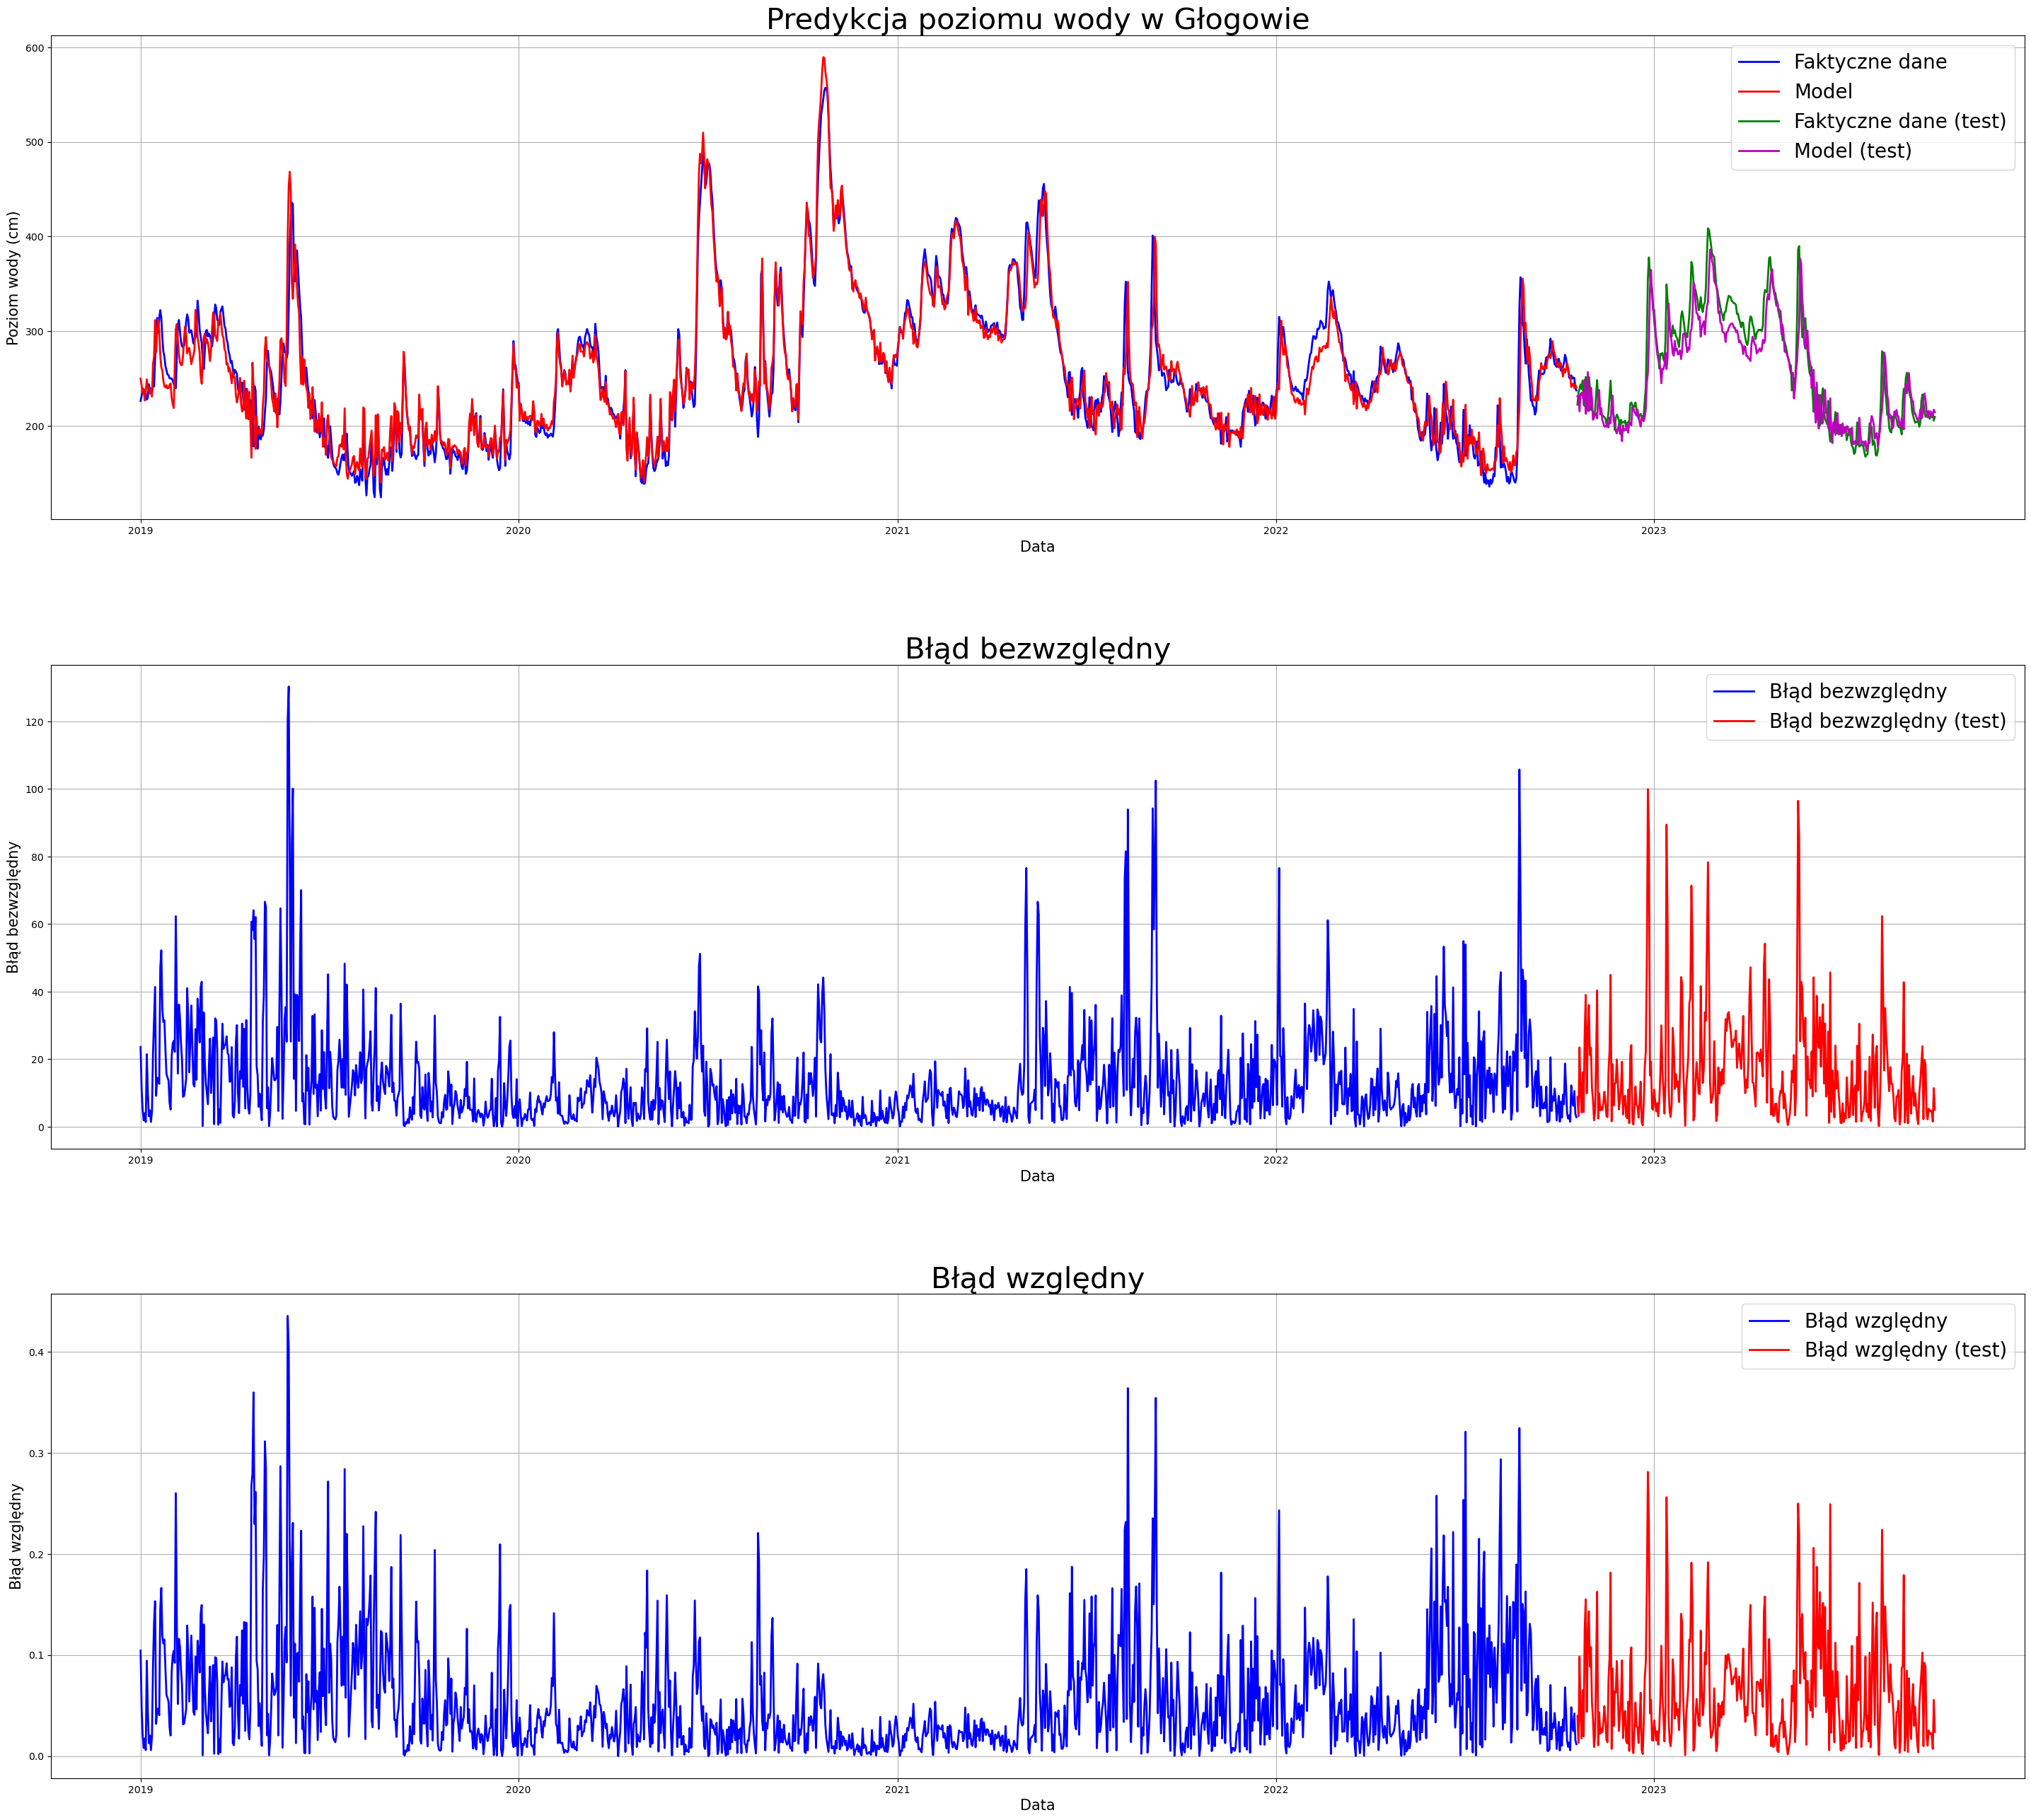

In [18]:
# Tymczasowa oś X, trzeba będzie zmienić na prawdziwą datę
train_dates = station_datas[0]['Date'][:len(train_data)]
test_dates = station_datas[0]['Date'][len(train_data):len(train_data) + len(test_data)]

# Okno wykresów
fig, axes = plt.subplots(figsize=(36, 32), nrows=3, ncols=1, gridspec_kw={'hspace': 0.3})

# Wykres predykcji
axes[0].plot(train_dates, train_data['GŁOGÓW'], color='b', label='Faktyczne dane', linewidth=2)
axes[0].plot(train_dates, model_prediction, 'r', label='Model', linewidth=2)
axes[0].plot(test_dates, test_data['GŁOGÓW'], color='g', label='Faktyczne dane (test)', linewidth=2)
axes[0].plot(test_dates, test_predict, color='m', label='Model (test)', linewidth=2)
axes[0].set_xlabel('Data', fontsize=15)
axes[0].set_ylabel('Poziom wody (cm)', fontsize=15)
axes[0].set_title('Predykcja poziomu wody w Głogowie', fontsize=30)
axes[0].legend(loc='upper right', fontsize=20)
axes[0].grid()

# Wykres błędu bezwzględnego
axes[1].plot(train_dates, train_absolute_error, color='b', label='Błąd bezwzględny', linewidth=2)
axes[1].plot(test_dates, test_absolute_error, color='r', label='Błąd bezwzględny (test)', linewidth=2)
axes[1].set_xlabel('Data', fontsize=15)
axes[1].set_ylabel('Błąd bezwzględny', fontsize=15)
axes[1].set_title('Błąd bezwzględny', fontsize=30)
axes[1].legend(loc='upper right', fontsize=20)
axes[1].grid()

# Wykres błędu względnego
axes[2].plot(train_dates, train_relative_error, color='b', label='Błąd względny', linewidth=2)
axes[2].plot(test_dates, test_relative_error, color='r', label='Błąd względny (test)', linewidth=2)
axes[2].set_xlabel('Data', fontsize=15)
axes[2].set_ylabel('Błąd względny', fontsize=15)
axes[2].set_title('Błąd względny', fontsize=30)
axes[2].legend(loc='upper right', fontsize=20)
axes[2].grid()

# Wyświetlenie wykresów
plt.show()

## Korelacje Pearsona między stacjami

In [ ]:
# Funkcja do liczenia korelacji Pearsona między dwiema stacjami
def correlation_between_stations(station_1, station_2, lag):
    station_1_id = stations.index(station_1.upper())
    station_2_id = stations.index(station_2.upper())
    correlation = lagged_dfs[lag][station_1_id]['B00020S'].corr(lagged_dfs[0][station_2_id]['B00020S'])
    return round(correlation, 3)

# Stacje
stations = ['GŁOGÓW', 'ŚCINAWA', 'MALCZYCE', 'BRZEG DOLNY', 'OŁAWA', 'BRZEG', 'RACIBÓRZ-MIEDONIA', 'KRZYŻANOWICE', 'OLZA', 'CHAŁUPKI']

# Grupowanie po dniach i stacjach
data_grouped = data.groupby(['Date', 'Station'])['B00020S'].mean().reset_index()

# Maksymalny lag
max_lag = 7

# Lista od 0 do max_lag
lags = range(max_lag + 1)

# Dwuwymiarowa lista zlagowanych dataframe'ów stacji
# Dostęp do wybranej stacji i lagu: lagged_dfs[lag][id_stacji np. 0 dla Głogowa]
start_date = '2008-01-08'
end_date = '2023-09-30'
lagged_dfs =[[data_grouped[(data_grouped['Date']
                .between(
                    pd.to_datetime(start_date) - pd.DateOffset(days=lag),
                    pd.to_datetime(end_date) - pd.DateOffset(days=lag)
                ))&(data_grouped['Station'] == station)].reset_index(drop=True) for station in stations]for lag in lags
             ]

# Lista stacji, dla których chcemy obliczyć korelację Pearsona względem Głogowa
stations_to_calculate_corr = ['ŚCINAWA', 'MALCZYCE']

# Wyświetlanie korelacji Pearsona
for station in stations_to_calculate_corr:
    print(f"\nWspółczynnik korelacji Pearsona liczony na podstawie poziomu wody w stacjach: {station.capitalize()} - Głogów")
    for lag in lags:
        print(f"Lag: {lag}, p = {correlation_between_stations(station, 'Głogów', lag)}")

In [17]:
len(test_data)

346

In [16]:
station_datas[0]['Date'][len(train_data):len(train_data) + len(test_data)]

1383   2022-10-19
1384   2022-10-20
1385   2022-10-21
1386   2022-10-22
1387   2022-10-23
          ...    
1724   2023-09-25
1725   2023-09-26
1726   2023-09-27
1727   2023-09-28
1728   2023-09-29
Name: Date, Length: 346, dtype: datetime64[ns]